<a href="https://colab.research.google.com/github/kamilakesbi/notebooks/blob/main/synthetic_pipeline_diarizers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🤗 Generate synthetic speaker diarization datas with Diarizers


## Introduction

Speaker diarisation systems often require large amounts of annotated data for training, but in practice such data is limited.

To overcome this limitation, recent research works has focused on the creation of simulated speaker diarisation datasets ([1](https://arxiv.org/pdf/1909.05952), [2](https://arxiv.org/pdf/2211.06750), [3](https://arxiv.org/pdf/2310.12371)) . These datasets are created by concatenating audio segments of individual speakers from Automatic Speech Recognition datasets to form artificial multi-speaker conversations.

We release a pipeline for synthetic speaker diarization dataset generation. This pipeline is compatible with 🤗[Diarizers](https://github.com/huggingface/diarizers), our library to fine-tune pyannote speaker diarization models.

In this tutorial, we introduce the pipeline, explaining its functionality and the various parameters it includes. We than generate a 20 hours dataset of simulated japanese conversation.


We see this pipeline as a useful research tool accompanying 🤗 Diarizers that can be used by researchers to build better speaker diarization systems.


Note: While this pipeline can be used to quickly generate multilingual synthetic data, it doesn't necessarily mean that using it for fine-tuning will necessarily improve performance on a target language. For speaker diarization, using in-domain datas is still the best way to improve performance. However, combining synthetic datas with in-domain datas (first by pretraining the model on synthetic and fine-tunning on in-domain datas) can often help boost performance.



## Prepare environement

First of all, let's try to secure a decent GPU for our Colab! Unfortunately, it's becoming much harder to get access to a good GPU with the free version of Google Colab. However, with Google Colab Pro one should have no issues in being allocated a V100 or P100 GPU.

To get a GPU, click Runtime -> Change runtime type, then change Hardware accelerator from CPU to one of the available GPUs, e.g. T4 (or better if you have one available). Next, click Connect T4 in the top right-hand corner of your screen (or Connect {V100, A100} if you selected a different GPU).

We can verify that we've been assigned a GPU and view its specifications:

In [8]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

/bin/bash: line 1: nvidia-smi: command not found


To use the synthetic pipeline, we will need to install `diarizers`. Simply run the following line of code to install the `diarizers` package:

In [ ]:
!pip install --upgrade --quiet git+https://github.com/kamilakesbi/diarizers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.3/92.3 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 873.5/873.5 kB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.3/82.3 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.8/49.8 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.9 MB/s eta 0:00:00
     ━━━━━━

To create synthetic speaker diarization datasets, we will use samples from Automatic Speech Recognition datasets ([Mutlilingual Librispeech](https://huggingface.co/datasets/facebook/multilingual_librispeech) / [CommonVoice](https://huggingface.co/datasets/mozilla-foundation/common_voice_17_0) / [Voxpopuli](https://huggingface.co/datasets/facebook/voxpopuli)). In this notebook, we will use the `common_voice_17` dataset. You will need to accept its terms-of-use:

- [mozilla-foundation/common_voice_17_0](https://huggingface.co/datasets/mozilla-foundation/common_voice_17_0)


You'll then need to enter your
Hub authentication token. Find your Hub authentication token [here](https://huggingface.co/settings/tokens).

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

## Choose an Automatic Speech Recognition dataset as a starting point

The pipeline uses samples from [Automatic Speech Recognition]((https://huggingface.co/datasets?task_categories=task_categories:automatic-speech-recognition&sort=trending) datasets as a starting point.

To be compatible with the pipeline, the ASR dataset needs to contain at least two features:  

- `audio`: Each audio segment must contain only one individual speaking.

- `speaker`: We must have access to a speaker ID associated with each audio segment.

In this tutorial, we will use the japanese subset of the `common_voice_17_0` dataset to generate synthetic japanese meetings.

Lets first load the `common_voice_17_0` dataset and listen to an example:


In [ ]:
from datasets import load_dataset

dataset = load_dataset('mozilla-foundation/common_voice_17_0', 'ja', split='validated', streaming=True)

/usr/local/lib/python3.10/dist-packages/datasets/load.py:1486: FutureWarning: The repository for mozilla-foundation/common_voice_17_0 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/mozilla-foundation/common_voice_17_0
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [ ]:
from IPython.display import Audio, display

example1 = next(iter(dataset))

print('Speaker id: ', example1['client_id'])

print('Audio: ')
display(Audio(example1['audio']['array'], rate=example1['audio']['sampling_rate']))

Reading metadata...: 93022it [00:03, 24061.38it/s]


Speaker id:  004a974ec0e77c3c846ac5d7dbef70cdd6329682f98c2ee7c14fd9a333a683d5f433d9beda70f415c5adabb80b220254b74b4eb6ab058b7b067c51ca8cb96c8a
Audio: 


Great! This audio example does contain a single speaker and we can indeed access its corresponding speaker id.

The speaker IDs will be useful when concatenating audio segments in the pipeline to annotate the generated synthetic meetings.

Lets now use the `diarizers` pipeline to create a synthetic dataset. We will need to use two classes:

- `SyntheticDataset` is the main class for creating synthetic data. It takes an instance of `SyntheticDatasetConfig` as input. This class contains a `generate` method that can be used to create the synthetic dataset, as will be demonstrated later in this tutorial.

- `SyntheticDatasetConfig` is the configuration class associated to `SyntheticDataset`. This is where we define all the parameters associated to the synthetic meetings we want to generate. Most of these parameters will be introduced in this tutorial.

To create our first synthetic dataset, we specify the following parameters in `SyntheticDatasetConfig`:  

- `dataset_name`: name of the ASR dataset used as a starting point.  
- `subset`: subset of the ASR dataset (if any).  
- `split`: split of the ASR dataset (if any).
- `audio_column_name`: name of the audio column feature in the ASR dataset.
- `speaker_column_name`: name of the speaker column feature in the ASR dataset.
- `nb_speakers_from_dataset`: Number of speakers to keep for synthetic meeting generation. The speakers with the highest number of audio segments will be kept. Here we set the value to -1 to keep all speakers.

- `min_samples_per_speaker`: Minimum number of audio segments associated with a speaker ID to be considered as a potential speaker in the generated meetings.  This parameter is used to filter the ASR dataset and only keep audio segments from speakers with a sufficient number of audio segments. In the next example we set this parameter to 10, meaning that we will only keep speakers with at least 10 audio segments for synthetic meeting generation.

- `sample_rate`: The sample of the target generated meetings.

Note that the other parameters will be set to default values. The ther parameters and their defualt values can be found [here](https://github.com/kamilakesbi/diarizers/blob/7335fda972d2a00dcf8011b6a9855247e26fcdad/src/diarizers/data/synthetic_pipeline.py#L18).

In [ ]:
from diarizers import SyntheticDataset, SyntheticDatasetConfig

synthetic_dataset_config = SyntheticDatasetConfig(
    dataset_name='mozilla-foundation/common_voice_17_0',
    subset='validated',
    split='ja',
    audio_column_name = "audio",
    speaker_column_name = "client_id",
    nb_speakers_from_dataset=-1,
    min_samples_per_speaker=10,
    sample_rate=16000,
)

synthetic_dataset = SyntheticDataset(synthetic_dataset_config)

Generating train split: 0 examples [00:00, ? examples/s]


Reading metadata...: 0it [00:00, ?it/s]
Reading metadata...: 10039it [00:00, 68597.44it/s]


Generating validation split: 0 examples [00:00, ? examples/s]


Reading metadata...: 0it [00:00, ?it/s]
Reading metadata...: 6261it [00:00, 54557.94it/s]


Generating test split: 0 examples [00:00, ? examples/s]


Reading metadata...: 0it [00:00, ?it/s]
Reading metadata...: 6261it [00:00, 25179.00it/s]


Generating other split: 0 examples [00:00, ? examples/s]


Reading metadata...: 0it [00:00, ?it/s]
Reading metadata...: 5684it [00:00, 56710.93it/s]
Reading metadata...: 11356it [00:00, 55142.30it/s]
Reading metadata...: 16874it [00:00, 49287.42it/s]
Reading metadata...: 21864it [00:00, 43111.82it/s]
Reading metadata...: 27926it [00:00, 48572.48it/s]
Reading metadata...: 32938it [00:00, 48262.07it/s]
Reading metadata...: 38907it [00:00, 51715.66it/s]
Reading metadata...: 44174it [00:00, 49451.92it/s]
Reading metadata...: 49322it [00:00, 50039.32it/s]
Reading metadata...: 54384it [00:01, 49488.26it/s]
Reading metadata...: 61508it [00:01, 55840.52it/s]
Reading metadata...: 71104it [00:01, 67656.05it/s]
Reading metadata...: 79403it [00:01, 72182.29it/s]
Reading metadata...: 87382it [00:01, 74013.31it/s]
Reading metadata...: 96276it [00:01, 78441.71it/s]
Reading metadata...: 104159it [00:01, 77674.27it/s]
Reading metadata...: 113014it [00:01, 80878.28it/s]
Reading metadata...: 122099it [00:01, 83839.98it/s]
Reading metadata...: 130548it [00:02, 8

Generating invalidated split: 0 examples [00:00, ? examples/s]


Reading metadata...: 0it [00:00, ?it/s]
Reading metadata...: 13547it [00:00, 80232.36it/s]


Generating validated split: 0 examples [00:00, ? examples/s]


Reading metadata...: 0it [00:00, ?it/s]
Reading metadata...: 4516it [00:00, 45155.41it/s]
Reading metadata...: 10214it [00:00, 52101.88it/s]
Reading metadata...: 15898it [00:00, 54261.40it/s]
Reading metadata...: 21928it [00:00, 56640.17it/s]
Reading metadata...: 27592it [00:00, 56404.77it/s]
Reading metadata...: 33233it [00:00, 55501.75it/s]
Reading metadata...: 38786it [00:00, 52129.91it/s]
Reading metadata...: 44036it [00:00, 51707.65it/s]
Reading metadata...: 49231it [00:00, 51045.36it/s]
Reading metadata...: 54856it [00:01, 52586.75it/s]
Reading metadata...: 60803it [00:01, 54631.38it/s]
Reading metadata...: 66284it [00:01, 52581.17it/s]
Reading metadata...: 71568it [00:01, 52516.71it/s]
Reading metadata...: 77250it [00:01, 53774.75it/s]
Reading metadata...: 82644it [00:01, 52755.10it/s]
Reading metadata...: 93022it [00:01, 54472.72it/s]


nb speakers in dataset to keep: 1348


Filter (num_proc=2):   0%|          | 0/93022 [00:00<?, ? examples/s]

Upon initialization, `SyntheticDataset` filters the ASR dataset to retain only the relevant features, as specified by audio_column_name and speaker_column_name. It also selects samples associated with the chosen speakers, based on the parameters nb_speakers_from_dataset and min_samples_per_speaker.

Here, With our synthetic_dataset example, we get 1348 speakers with at least 10 associated audio segments:

In [ ]:
print('Speakers that will be used for sampling: ', len(synthetic_dataset.speakers_to_sample_from))

Speakers that will be used for sampling:  1348


We can keep only the 200 speakers with most audio segments with the `nb_speakers_from_dataset` parameter:  

In [10]:
synthetic_dataset_config.nb_speakers_from_dataset=200

synthetic_dataset = SyntheticDataset(synthetic_dataset_config)

print('Speakers that will be used for sampling: ', len(synthetic_dataset.speakers_to_sample_from))

nb speakers in dataset to keep: 200


Filter (num_proc=2):   0%|          | 0/93022 [00:00<?, ? examples/s]

100%|██████████| 200/200 [00:00<00:00, 136112.41it/s]
Downloading: "https://github.com/snakers4/silero-vad/zipball/master" to /root/.cache/torch/hub/master.zip


Speakers that will be used for sampling:  200


## Synthetic Meetings Properties

Before using the `generate` method from `SyntheticDataset` to generate synthetic meetings, there are a few other important parameters that needs to be specified:

- `num_meetings`: number of synthetic meetings to be generated.
- `nb_speakers_per_meeting`: Number of speakers per meeting. We will set this value to 3 in the following examples.
- `segments_per_meeting`: Number of audio segments per created meeting. In the following examples, we will set this value to 16 to generate ~1min meetings.
- `overlap_proba`: Probablity of overlap between successive speakers.
- `silence_proba`: Probability of having areas of silence (where no speaker is talking) in a generated meeting.

Let's generate a first synthetic meeting examples:  

In [11]:
synthetic_dataset_config = SyntheticDatasetConfig(
    dataset_name='mozilla-foundation/common_voice_17_0',
    subset='validated',
    split='ja',
    min_samples_per_speaker=10,
    audio_column_name = "audio",
    speaker_column_name = "client_id",
    nb_speakers_from_dataset=3,
    num_meetings=2,
    nb_speakers_per_meeting=3,
    segments_per_meeting=16,
    overlap_proba=0,
    silence_proba=0,
    num_proc=1,
)

synthetic_dataset = SyntheticDataset(synthetic_dataset_config).generate()

nb speakers in dataset to keep: 3


Filter:   0%|          | 0/93022 [00:00<?, ? examples/s]

100%|██████████| 3/3 [00:00<00:00, 2710.08it/s]
Downloading: "https://github.com/snakers4/silero-vad/zipball/master" to /root/.cache/torch/hub/master.zip
100%|██████████| 2/2 [00:00<00:00, 42.96it/s]
Parameter 'function'=<bound method SyntheticDataset.concatenate of <diarizers.data.synthetic_pipeline.SyntheticDataset object at 0x7f7e99823670>> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/32 [00:00<?, ? examples/s]

TypeError: SyntheticDataset.concatenate() missing 1 required positional argument: 'rank'

Let's listen to the generated meeting, and visualize its corresponding annotations:

In [ ]:
example1 = synthetic_dataset[0]

display(Audio(example1['audio']['array'], rate=example1['audio']['sampling_rate']))

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_meeting(dataset, sample=0):

    timestamps_start = dataset[sample]['timestamps_start']
    timestamps_end = dataset[sample]['timestamps_end']
    speakers = dataset[sample]['speakers']
    print(len(timestamps_start))
    speaker_labels = list(set(speakers))

    per_speaker_timestamps = {}

    for speaker_to_filter in speaker_labels:

        indices = [i for i, spk in enumerate(speakers) if spk == speaker_to_filter]

        timestamps_start_spk = [timestamps_start[i] for i in indices]
        timestamps_end_spk = [timestamps_end[i] - timestamps_start[i] for i in indices]

        per_speaker_timestamps[speaker_to_filter] = list(zip(timestamps_start_spk, timestamps_end_spk))

    # Set up the figure and axis
    fig, ax = plt.subplots(figsize = (10, 5))
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
    colors += ['#{:06x}'.format(np.random.randint(0, 16777215)) for _ in range(len(speaker_labels) - 4)]

    i = 0
    labels = []
    label_positions = []

    for key, value in per_speaker_timestamps.items():
        ax.broken_barh(value, (0.3*i, 0.5), facecolors = colors[i])
        label_positions.append(0.3*i + 0.25)
        i+=1
        labels.append(key)

    ax.set_xlabel('seconds since start')
    ax.set_yticks(label_positions, labels=[i for i in range(len(speaker_labels))])
    ax.set_ylabel('speaker')
    ax.grid(True)

    plt.title('dataset: {} - sample number {}'.format(dataset.info.dataset_name, sample))


19


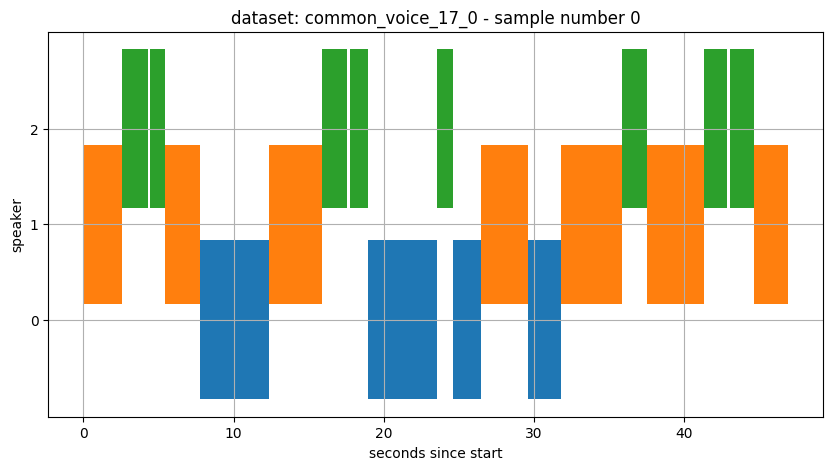

In [ ]:
plot_meeting(synthetic_dataset, sample=0)

Nice! we have just created a 47 second synthetic meeting with 3 talking speakers :) We can see that, as specified in the configuration, there is no overlap between successive speakers and no periods of silence!

To understand how we get this result, let's break down the main steps of the algorithm:

- First, we sample the audio segments used for each generated meeting: we start by randomly sampling `nb_speakers_per_meeting` from the filtered ASR dataset and iteratively fill an empty batch with sampled audio segments from the selected speakers. The algorithm ensures that no audio segments are used twice in a generated meeting, and that consecutive audio segments belong to different speakers.

- To get accurate speaker timestamps for each audio segment, the timestamps are refined using a voice activity detector. We also crop the beginning and end of each audio segment to remove unwanted areas of silence.

- Once the meeting batch of refined audio segments has been generated, we can start concatenating them. To simulate natural human conversation, a small gap pause is inserted between successive speaker turns and sampled from a Rayleigh distribution with a scale parameter (mode) of 200ms. This is inspired by published statistics of natural conversation ([Heldner, M., Edlund, J: Pauses, gaps and overlap in conversations, 2010](https://www.sciencedirect.com/science/article/abs/pii/S0095447010000628)). After this step, we obtain our generated audio meetings with their corresponding annotations!


There are also some additional optional steps you can consider:

- Introduce overlap between successive audio segments or insert regions of silence in the final generated meeting. This can create a more natural conversation and help smooth transitions.

- Modify the gain of each segment to increase the volume of some speakers.

- Denoise the final generated meetings to preserve only the speakers' voices. In fact, recording conditions may vary from one audio segment to another, and it may be useful to denoise the final meeting to ensure that there are no differences in background noise between successive segments.

- Add background noise and reverberation to the generated meetings.

In the following section, we will see how we can add overlap and regions of silence to the generated meetings:

### Add Silence and Overlap

Let's add silence and overlap to the generated meetings. Here, we will change the following parameters

- `overlap_proba`: we set this value to 0.5. This means that there is a 30% chance that two consecutive audio segments will overlap.
- `overlap_length`: This is the maximum overlap time between two consecutive audio segments. Here we set it to 3 seconds.
- `silence_proba`: Probability of having a region of silence in the generated meeting. We set this to 1 to ensure that we have a period of silence in the generated meeting.
- `silence_duration`: Maximum duration of the silent zone. We set this to 2 seconds.  

In [12]:
synthetic_dataset_config.overlap_proba = 0.5
synthetic_dataset_config.overlap_length = 3

synthetic_dataset_config.silence_proba = 1
synthetic_dataset_config.silence_duration = 2

In [ ]:
synthetic_dataset = SyntheticDataset(synthetic_dataset_config).generate()

nb speakers in dataset to keep: 3


Filter:   0%|          | 0/93022 [00:00<?, ? examples/s]

100%|██████████| 3/3 [00:00<00:00, 6410.04it/s]
Downloading: "https://github.com/snakers4/silero-vad/zipball/master" to /root/.cache/torch/hub/master.zip
100%|██████████| 2/2 [00:00<00:00, 91.08it/s]


Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Let's listen to the generated meeting:

In [ ]:
from IPython.display import Audio, display

example = synthetic_dataset[0]

display(Audio(example['audio']['array'], rate=example['audio']['sampling_rate']))

And visualize its corresponding annotations:

19


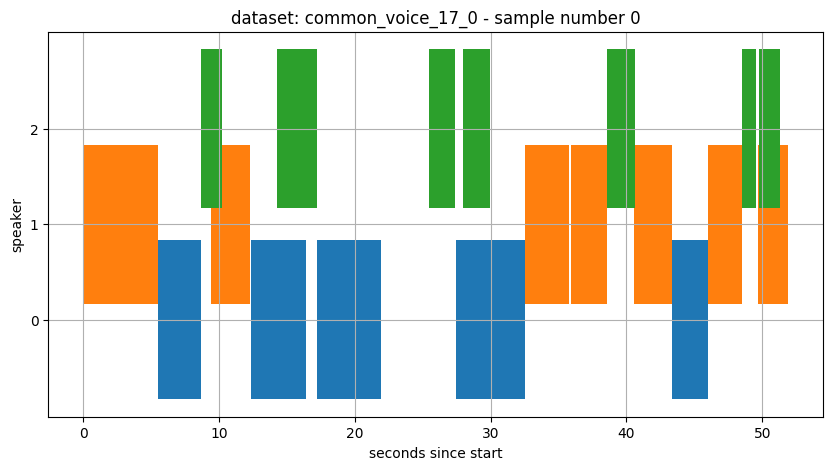

In [ ]:
plot_meeting(synthetic_dataset, sample=0)

We can see that we have indeed forced overlap between speakers and added a region of silence 🤗. We can play with these hyperparameters to get a synthetic dataset with the proportions of overlap and silence we need!

As mentionned previously, we can play with the other parameters if we want to augment our synthetic dataset with background noise, reverberatio or gain. Feel free to experiment here 🤗

## Generate a Large Synthetic Speaker Diarization Dataset

Let's create a large synthetic dataset with more than 20 hours of Japanese conversations. We will create a dataset with 1600 generated meetings and 3 speakers per meeting.

Here are all the hyperparameters we will use to generate this dataset:  

In [ ]:
synthetic_dataset_config = SyntheticDatasetConfig(
    dataset_name =  "mozilla-foundation/common_voice_17_0",
    subset = "validated",
    split = "ja",
    speaker_column_name = "client_id",
    audio_column_name = "audio",
    min_samples_per_speaker = 10,
    nb_speakers_from_dataset = 200,
    sample_rate  = 16000,
    num_meetings = 800,
    nb_speakers_per_meeting = 3,
    segments_per_meeting = 16,
    normalize = True,
    overlap_proba = 0.3,
    overlap_length = 3,
    random_gain = False,
    add_silence = True,
    silence_duration = 3,
    silence_proba = 0.7,
    denoise = False,
    num_proc = 2
)

In [ ]:
synthetic_dataset = SyntheticDataset(synthetic_dataset_config).generate()

That's it! we've generated our first synthetic speaker diarization dataset compatible with 🤗 Diarizers. You can push it to the hub using the following command line:

In [ ]:
synthetic_dataset.push_to_hub("synthetic-speaker-diarization-dataset-jpn")

Each of these syntehtic datasets can be used to train a pyanote segmentation model using 🤗 Diarizers.

For more information on how to use Diarizers for training models, please refer to the official [diarizers repository](https://github.com/huggingface/diarizers) or the [associated notebook](https://colab.research.google.com/github/kamilakesbi/notebooks/blob/main/fine_tune_pyannote.ipynb), which contains a detailed tutorial on how to use Diarizers.

### Closing remarks:

In this notebook, we present a synthetic pipeline for generating synthetic speaker diarisation data that is compatible with 🤗 Diarizers.

This tool can help researchers to build better speaker diarisation systems by allowing them to quickly generate synthetic data with different statistical properties and see how new systems behave on them.

While synthetic datasets is a promising research direction for training performant speaker diarization systems, note that we still encourage fine-tunning models on in-domain real data to get the best performance improvements.